In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/MusicalMoods/CK+.zip' CK+.zip
drive.flush_and_unmount()

In [ ]:
!unzip CK+.zip

In [ ]:
!mkdir CK+/ImagesUnzipped
!unzip "CK+/*.zip" -d CK+/ImagesUnzipped/.

In [ ]:
!pip install mtcnn

In [9]:
import os
import glob
import cv2
from mtcnn.mtcnn import MTCNN
root_path = "CK+/ImagesUnzipped/"
images_path = root_path+"Images/"
emotions_path = root_path + "Emotion/"

In [30]:
detector = MTCNN()
def detect_face(detect_image_path):
  face_image = cv2.imread(detect_image_path)
  location = detector.detect_faces(face_image)
  if len(location) > 0:
    for face in location:
      x1,y1,w,h = face['box']
      x2,y2=x1+w,y1+h
      face_image = face_image[y1:y2, x1:x2]
      print(face_image.shape)

      if face_image.shape[0] == 0 or face_image.shape[1] == 0 or face_image.shape[2] == 0:
        continue
      face_image = cv2.resize(face_image, (64, 64))
  return face_image

In [7]:
Dataset_path = "Dataset/"
!rm -rf $Dataset_path
!mkdir $Dataset_path

In [8]:
for i in range(8):
  output_dir = Dataset_path+str(i)
  !mkdir $output_dir

In [ ]:
for path,directories,files in os.walk(emotions_path):
    for file in files:
      label_path = os.path.join(path, file)
      image_path = path.replace('Emotion','cohn-kanade-images')
      imgFiles = glob.glob(image_path+"/*.png")
      imgFiles = sorted(imgFiles)
      emotion_image_path1 = imgFiles[-1]
      emotion_image_path2 = imgFiles[-2]
      neutral_image_path = imgFiles[0]
      emotion_image1 = detect_face(emotion_image_path1)
      emotion_image2 = detect_face(emotion_image_path2)
      neutral_image = detect_face(neutral_image_path)
      emotion_output_file_name1 = emotion_image_path1[emotion_image_path1.rfind("/")+1:]
      emotion_output_file_name2 = emotion_image_path2[emotion_image_path2.rfind("/")+1:]
      label = 0
      neutral_output_file_name = neutral_image_path[neutral_image_path.rfind("/")+1:]
      neutral_output_file_name = Dataset_path+str(label)+"/"+neutral_output_file_name
      if neutral_image.shape[0]!=0:
        cv2.imwrite(neutral_output_file_name,neutral_image)
      with open(label_path, 'r') as f: 
        label = int(float(f.read()))
      emotion_output_file_name1 = Dataset_path+str(label)+"/"+emotion_output_file_name1
      emotion_output_file_name2 = Dataset_path+str(label)+"/"+emotion_output_file_name2
      if emotion_image1.shape[0]!=0:
        cv2.imwrite(emotion_output_file_name1,emotion_image1)
      if emotion_image2.shape[0]!=0:
        cv2.imwrite(emotion_output_file_name2,emotion_image2)           

In [ ]:
Test_path = "Test_Dataset_CK+/"
!rm -rf $Test_path
!mkdir $Test_path

for i in range(8):
  output_dir = Test_path+str(i)
  !mkdir $output_dir

for path,directories,files in os.walk(emotions_path):
    for file in files:
      label_path = os.path.join(path, file)
      image_path = path.replace('Emotion','cohn-kanade-images')
      imgFiles = glob.glob(image_path+"/*.png")
      imgFiles = sorted(imgFiles)
      emotion_image_path1 = imgFiles[-3]
      neutral_image_path = imgFiles[1]
      emotion_image1 = detect_face(emotion_image_path1)
      neutral_image = detect_face(neutral_image_path)
      emotion_output_file_name1 = emotion_image_path1[emotion_image_path1.rfind("/")+1:]
      label = 0
      neutral_output_file_name = neutral_image_path[neutral_image_path.rfind("/")+1:]
      neutral_output_file_name = Test_path+str(label)+"/"+neutral_output_file_name
      if neutral_image.shape[0]!=0:
        cv2.imwrite(neutral_output_file_name,neutral_image)
      with open(label_path, 'r') as f: 
        label = int(float(f.read()))
      emotion_output_file_name1 = Test_path+str(label)+"/"+emotion_output_file_name1
      if emotion_image1.shape[0]!=0:
        cv2.imwrite(emotion_output_file_name1,emotion_image1) 

In [ ]:
drive.mount('/content/drive')
!cp -r $Test_path '/content/drive/MyDrive/MusicalMoods/Test_Dataset_CK+_mtcnn'
!cp -r $Dataset_path '/content/drive/MyDrive/MusicalMoods/Dataset_CK+_mtcnn'
drive.flush_and_unmount()

In [ ]:
Dataset_path = "Dataset/"
Test_path = "Test_Dataset_CK+/"

drive.mount('/content/drive')
!cp -r '/content/drive/MyDrive/MusicalMoods/Test_Dataset_CK+_mtcnn' $Test_path
!cp -r '/content/drive/MyDrive/MusicalMoods/Dataset_CK+_mtcnn' $Dataset_path
drive.flush_and_unmount()

In [5]:
!rm -r 'Test_Dataset_CK+/2'
!rm -r 'Dataset/2'

In [6]:
import keras
from keras.models import Model
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers

In [10]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,  
    samplewise_center=False,  
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=0,  
    width_shift_range=0.0, 
    height_shift_range=0.0, 
    horizontal_flip=True,
    vertical_flip=False,
)


In [ ]:
train_generator = image_gen.flow_from_directory(
    'Dataset',
    color_mode='grayscale',
    target_size=(224,224),
    batch_size=4,
    class_mode='categorical',
    shuffle=True
)

In [ ]:
test_generator = image_gen.flow_from_directory(
    'Test_Dataset_CK+',
    color_mode='grayscale',
    target_size=(224,224),
    batch_size=4,
    class_mode='categorical',
    shuffle=True
)

In [33]:
from keras import backend as K
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    y_pred = K.clip(y_pred, 0, 1)

    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [34]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D
from keras.models import Sequential
model = Sequential()

model.add(Convolution2D(64, (3, 1), padding='same', input_shape=(224,224,1)))
model.add(Convolution2D(64, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 1), padding='same'))
model.add(Convolution2D(128, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(256, (3, 1), padding='same'))
model.add(Convolution2D(256, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(512, (3, 1), padding='same'))
model.add(Convolution2D(512, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      256       
                                                                 
 conv2d_41 (Conv2D)          (None, 224, 224, 64)      12352     
                                                                 
 batch_normalization_30 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 112, 112, 64)     

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/MusicalMoods/EmotionVgg_model.h5",
    monitor='val_acc',
    save_best_only=True,
    verbose=1,
    period =1,
    mode='auto'
)

early = EarlyStopping(
    monitor='val_acc',
    patience=7,
    verbose=1,
    mode='auto',
    min_delta=0
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    cooldown=0,
    min_lr=0
)

hist = model.fit_generator(generator=train_generator,validation_data=test_generator,callbacks=[checkpoint,early,reduce_lr],epochs=40)



Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


236/236 [==============================] - ETA: 0s - loss: 0.9485 - fbeta: 0.5678 - acc: 0.6716
Epoch 1: val_acc improved from -inf to 0.58136, saving model to /content/drive/MyDrive/MusicalMoods/EmotionVgg_model.h5
236/236 [==============================] - 910s 4s/step - loss: 0.9485 - fbeta: 0.5678 - acc: 0.6716 - val_loss: 1.0651 - val_fbeta: 0.4167 - val_acc: 0.5814 - lr: 0.0010
Epoch 2/40
236/236 [==============================] - ETA: 0s - loss: 0.8752 - fbeta: 0.6197 - acc: 0.7067
Epoch 2: val_acc did not improve from 0.58136
236/236 [==============================] - 899s 4s/step - loss: 0.8752 - fbeta: 0.6197 - acc: 0.7067 - val_loss: 1.3585 - val_fbeta: 0.5283 - val_acc: 0.5782 - lr: 0.0010
Epoch 3/40
236/236 [==============================] - ETA: 0s - loss: 0.8299 - fbeta: 0.6441 - acc: 0.7163
Epoch 3: val_acc improved from 0.58136 to 0.76145, saving model to /content/drive/MyDrive/MusicalMoods/EmotionVgg_model.h5
236/236 [==============================] - 895s 4s/step - l

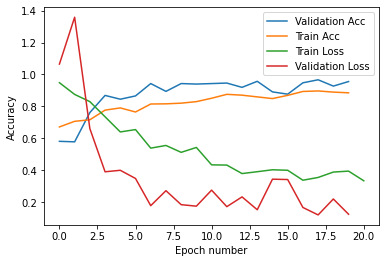

In [5]:
import matplotlib.pyplot as plt
plt.plot(history['val_acc'])
plt.plot(history['acc'])
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.legend(["Validation Acc","Train Acc","Train Loss","Validation Loss"])
plt.show()